# Purpose
To find indicators of fighter styles so that we can indicate what a fighter's strengths are. We will examine the distributions of the various metrics used in the current data set to see if there is any connection between any of the metrics and any particular fighting style. These styles include Wrestling, Brazilian Jiu Jitsu/Submission Grappling, Striking, and possibly Boxing, and Muay Thai.

In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
from src import local
from src import functions
    
# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# Data handling
import pandas as pd
from sqlalchemy import create_engine

# Math
import scipy

#### Load the data

In [2]:
# Set up tables
# Credentials
USER = local.user 
PASS = local.password
HOST = local.host
PORT = local.port

#create engine
engine = create_engine(f'postgresql://{USER}:{PASS}@{HOST}:{PORT}/match_finder')

### Striking
#### Objectives
1. Create Striking Score
2. Create Wrestling Score
3. Plot these Scores

### Create Striking Score
My Striking Score will be calculated based on the differentials for a fighter Standing Significant Strikes per 15 Minutes and Knockdowns per 15 Minutes. I will convert these into z-scores and then average them together.

In [3]:
query = """
SELECT
    striking_adv.bout_id, striking_adv.fighter_id, fighters.name, events.date,
    g_ss_s_p15m_di, td_s_p15m_di, ps_p15m_di, rev_p15m_di, sba_p15m_di,
    (d_ss_s_p15m_di + c_ss_s_p15m_di) as s_ss_s_p15m_di, kd_p15m_di
FROM striking_adv
JOIN grappling_adv ON 
    CONCAT(striking_adv.bout_id, striking_adv.fighter_id, CAST(striking_adv.round AS CHAR)) =
    CONCAT(grappling_adv.bout_id, grappling_adv.fighter_id, CAST(grappling_adv.round AS CHAR))
JOIN striking_position_adv ON 
    CONCAT(striking_adv.bout_id, striking_adv.fighter_id, CAST(striking_adv.round AS CHAR)) =
    CONCAT(striking_position_adv.bout_id, striking_position_adv.fighter_id, CAST(striking_position_adv.round AS CHAR))
JOIN bouts ON bouts.id = striking_adv.bout_id
JOIN events ON events.id = bouts.event_id
JOIN fighters ON fighters.id = striking_adv.fighter_id
"""

stats = pd.read_sql(query, engine)

In [4]:
stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25736 entries, 0 to 25735
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   bout_id         25736 non-null  object 
 1   fighter_id      25736 non-null  object 
 2   name            25736 non-null  object 
 3   date            25736 non-null  object 
 4   g_ss_s_p15m_di  25736 non-null  float64
 5   td_s_p15m_di    25736 non-null  float64
 6   ps_p15m_di      25736 non-null  float64
 7   rev_p15m_di     25736 non-null  float64
 8   sba_p15m_di     25736 non-null  float64
 9   s_ss_s_p15m_di  25736 non-null  float64
 10  kd_p15m_di      25736 non-null  float64
dtypes: float64(7), object(4)
memory usage: 2.2+ MB


##### Remove fighters with no fighter page

In [5]:
stats = stats[stats['fighter_id']!='no_link']

##### Convert date to datetime

In [6]:
stats['date'] = pd.to_datetime(stats['date'])

##### Group by fighter_id

In [7]:
stats_groupby = stats.groupby('fighter_id')

In [8]:
names = stats_groupby.name.max()

In [9]:
number_of_fights = stats_groupby.bout_id.unique().map(lambda x: len(x))

In [10]:
stats_by_fighter = stats_groupby.mean()

In [11]:
stats_by_fighter['bouts'] = number_of_fights
stats_by_fighter['name'] = names

In [12]:
stats_by_fighter

,g_ss_s_p15m_di,td_s_p15m_di,ps_p15m_di,rev_p15m_di,sba_p15m_di,s_ss_s_p15m_di,kd_p15m_di,bouts,name
fighter_id,,,,,,,,,
002ca196477ce572,-12.000000,-2.500000,-5.000000,0.000000,-0.500000,-20.500000,0.000000,2,Gabriel Silva
003d82fa384ca1d0,-148.235294,0.000000,-10.588235,0.000000,0.000000,-42.352941,0.000000,1,Aalon Cruz
0052de90691d4a93,1.664626,2.777748,3.437849,0.000000,1.718925,-13.386745,-0.176471,7,Davi Ramos
008dc37cca279def,-18.616109,-2.763982,-1.442553,-1.707447,7.407751,-6.328875,0.000000,3,Sean McCorkle
009341ed974bad72,0.000000,0.000000,0.000000,0.000000,0.000000,26.418367,9.183673,1,Jiri Prochazka
...,...,...,...,...,...,...,...,...,...
ff4c3ab594c7fac3,-5.419863,-0.818182,-1.090909,0.000000,0.000000,-5.289017,-0.272727,4,Cristiano Marcello
ff6a1f63c254127e,-0.993536,-1.622809,-3.224619,0.176471,-0.563986,10.238246,2.431847,8,Albert Tumenov
ffc088e64fab57e9,-3.449876,-1.234927,-1.311850,-0.076923,-0.927235,-1.851784,0.727496,13,Quinton Jackson


##### Remove fighters with less than 3 fights

In [13]:
exp_fighters = stats_by_fighter[stats_by_fighter['bouts']>=3]
exp_fighters

,g_ss_s_p15m_di,td_s_p15m_di,ps_p15m_di,rev_p15m_di,sba_p15m_di,s_ss_s_p15m_di,kd_p15m_di,bouts,name
fighter_id,,,,,,,,,
0052de90691d4a93,1.664626,2.777748,3.437849,0.000000,1.718925,-13.386745,-0.176471,7,Davi Ramos
008dc37cca279def,-18.616109,-2.763982,-1.442553,-1.707447,7.407751,-6.328875,0.000000,3,Sean McCorkle
00a3ff40c4b2cf21,-2.634033,0.333333,-1.000000,0.000000,0.349650,-14.130536,0.000000,3,Glaico Franca Moreira
00debc804e2b1cd4,0.224194,0.975539,-1.773361,-0.340136,-1.006803,1.428231,1.161716,5,Dylan Andrews
00e11b5c8b7bfeeb,22.089162,0.282156,2.518246,0.000000,2.200644,2.034522,-0.522573,10,Luke Rockhold
...,...,...,...,...,...,...,...,...,...
fef3d17e27e916e7,2.794014,0.000000,1.125000,0.000000,0.000000,-7.814687,0.979668,4,Antonio Carvalho
ff4c3ab594c7fac3,-5.419863,-0.818182,-1.090909,0.000000,0.000000,-5.289017,-0.272727,4,Cristiano Marcello
ff6a1f63c254127e,-0.993536,-1.622809,-3.224619,0.176471,-0.563986,10.238246,2.431847,8,Albert Tumenov


##### Calculate z score

In [14]:
z_scores_striking = exp_fighters[['s_ss_s_p15m_di', 'kd_p15m_di']].apply(scipy.stats.zscore)
z_scores_striking.columns = ['z_s_ss_s_p15m_di', 'z_kd_p15m_di']
z_scores_striking

,z_s_ss_s_p15m_di,z_kd_p15m_di
fighter_id,,
0052de90691d4a93,-0.667325,-0.014288
008dc37cca279def,-0.274515,0.048405
00a3ff40c4b2cf21,-0.708722,0.048405
00debc804e2b1cd4,0.157211,0.461115
00e11b5c8b7bfeeb,0.190955,-0.137244
...,...,...
fef3d17e27e916e7,-0.357209,0.396441
ff4c3ab594c7fac3,-0.216641,-0.048484
ff6a1f63c254127e,0.647538,0.912340


##### Average z-score columns for Striking Score

In [15]:
exp_fighters['striking_score'] = (z_scores_striking['z_kd_p15m_di'] + z_scores_striking['z_s_ss_s_p15m_di'])/2

<ipython-input-15-7d8abfc02816>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exp_fighters['striking_score'] = (z_scores_striking['z_kd_p15m_di'] + z_scores_striking['z_s_ss_s_p15m_di'])/2


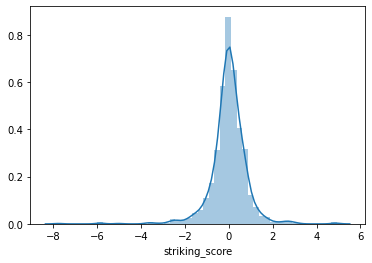

In [16]:
sns.distplot(exp_fighters['striking_score'])

In [17]:
exp_fighters.describe()

,g_ss_s_p15m_di,td_s_p15m_di,ps_p15m_di,rev_p15m_di,sba_p15m_di,s_ss_s_p15m_di,kd_p15m_di,bouts,striking_score
count,1243.000000,1243.000000,1243.000000,1243.000000,1243.000000,1243.000000,1243.000000,1243.000000,1.243000e+03
mean,-1.470205,-0.126824,-0.211246,-0.001733,-0.023809,-1.396485,-0.136253,7.992759,7.145442e-18
std,16.011697,2.015315,2.529548,0.396593,1.589072,17.974866,2.815982,5.551177,8.308359e-01
min,-144.784717,-6.670549,-17.371622,-3.252101,-15.564487,-129.971011,-36.000000,3.000000,-7.752954e+00
25%,-7.348485,-1.333333,-1.410352,-0.108836,-0.585124,-10.823771,-0.621142,4.000000,-3.018800e-01
50%,-0.662080,-0.236842,-0.114825,0.000000,0.000000,-1.546533,0.000000,6.000000,1.668396e-02
75%,5.968795,1.092742,1.188718,0.110925,0.527204,9.066998,0.500230,10.000000,3.703492e-01
max,73.321805,8.333333,13.220946,5.571429,19.497616,67.154036,23.275862,35.000000,4.914362e+00


##### Examine top fighters

In [18]:
exp_fighters.sort_values('striking_score', ascending=False).head(20)

,g_ss_s_p15m_di,td_s_p15m_di,ps_p15m_di,rev_p15m_di,sba_p15m_di,s_ss_s_p15m_di,kd_p15m_di,bouts,name,striking_score
fighter_id,,,,,,,,,,
9ccdd2ce45903f34,58.026229,-2.483309,-7.785033,0.000000,1.474138,25.759171,23.275862,3,Mark Weir,4.914362
bda04c573563cc2e,54.417298,-0.444295,0.000000,0.000000,0.000000,52.387740,18.583838,6,Todd Duffee,4.821936
f14cf73e51b29254,4.527507,-1.149425,0.000000,0.000000,0.000000,67.154036,6.835531,3,Sergei Pavlovich,3.146005
c21f26bbde777573,25.539759,-2.298088,-0.857143,0.000000,0.000000,27.079519,12.229385,5,Johnny Walker,2.988926
4123fd4dcc1fe937,36.746615,3.777563,0.504836,0.000000,4.282398,20.559961,12.500000,3,David Terrell,2.855570
2cd428e9606856fd,17.766667,-1.200000,-2.100000,0.300000,0.000000,31.143989,10.574169,5,Jairzinho Rozenstruik,2.808016
a7f4d0902bb64092,6.790275,-5.276480,-4.878582,0.503356,-0.172548,-3.574527,15.893056,10,James Irvin,2.786666
365fee2da473b177,15.985893,1.302722,0.304905,-0.056511,-0.850240,38.726076,8.697515,19,Anthony Johnson,2.685660
4144798612ef96e5,25.768887,5.583333,5.666667,0.000000,2.083333,53.907358,5.988185,4,Edmen Shahbazyan,2.626865


In [19]:
exp_fighters[exp_fighters['name']=='Anderson Silva']

,g_ss_s_p15m_di,td_s_p15m_di,ps_p15m_di,rev_p15m_di,sba_p15m_di,s_ss_s_p15m_di,kd_p15m_di,bouts,name,striking_score
fighter_id,,,,,,,,,,
1f454354805b6f75,3.559652,-0.828309,-0.820555,0.0,0.198123,15.721112,2.000995,24,Anderson Silva,0.855983


### Notes:
The striking score does capture some top performing strikers in the UFC with Conor McGregor and Jairzinho Rozenstruik in the top 20 of all time. One thing to note is that if you're using fights from a fighter who fought past their prime, you may not be able to make accurate comparisons. For instance, Anderson Silva, considered the best Middleweight striker of all time, is scored at .86, likely because he has not been as dominant in his most recent performances. This needs to be examined further by calculating the striking scores for fighters in their prime.

### Grappling Score

In [20]:
z_scores_grappling = exp_fighters[['g_ss_s_p15m_di', 'td_s_p15m_di', 'ps_p15m_di', 'rev_p15m_di', 'sba_p15m_di']].apply(scipy.stats.zscore)
z_scores_grappling.columns = ['z_g_ss_s_p15m_di', 'z_td_s_p15m_di', 'z_ps_p15m_di', 'z_rev_p15m_di', 'z_sba_p15m_di']
z_scores_grappling

,z_g_ss_s_p15m_di,z_td_s_p15m_di,z_ps_p15m_di,z_rev_p15m_di,z_sba_p15m_di
fighter_id,,,,,
0052de90691d4a93,0.195863,1.441830,1.443169,0.004370,1.097140
008dc37cca279def,-1.071267,-1.309085,-0.486965,-4.302653,4.678550
00a3ff40c4b2cf21,-0.072715,0.228422,-0.311942,0.004370,0.235112
00debc804e2b1cd4,0.105865,0.547213,-0.617795,-0.853621,-0.618845
00e11b5c8b7bfeeb,1.471977,0.203018,1.079478,0.004370,1.400408
...,...,...,...,...,...
fef3d17e27e916e7,0.266426,0.062955,0.528468,0.004370,0.014989
ff4c3ab594c7fac3,-0.246773,-0.343190,-0.347895,0.004370,0.014989
ff6a1f63c254127e,0.029782,-0.742607,-1.191749,0.449516,-0.340069


##### Combine z-score columns for Striking Score

In [21]:
exp_fighters['grappling_score'] = (z_scores_grappling['z_td_s_p15m_di'] + 
                                  z_scores_grappling['z_g_ss_s_p15m_di'] +
                                  z_scores_grappling['z_ps_p15m_di'] + 
                                  z_scores_grappling['z_rev_p15m_di']+
                                  z_scores_grappling['z_sba_p15m_di']) / 5

<ipython-input-21-ecb464be0da1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exp_fighters['grappling_score'] = (z_scores_grappling['z_td_s_p15m_di'] +


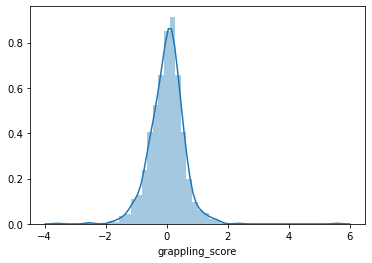

In [22]:
sns.distplot(exp_fighters['grappling_score'])

In [23]:
exp_fighters.describe()

,g_ss_s_p15m_di,td_s_p15m_di,ps_p15m_di,rev_p15m_di,sba_p15m_di,s_ss_s_p15m_di,kd_p15m_di,bouts,striking_score,grappling_score
count,1243.000000,1243.000000,1243.000000,1243.000000,1243.000000,1243.000000,1243.000000,1243.000000,1.243000e+03,1243.000000
mean,-1.470205,-0.126824,-0.211246,-0.001733,-0.023809,-1.396485,-0.136253,7.992759,7.145442e-18,0.000000
std,16.011697,2.015315,2.529548,0.396593,1.589072,17.974866,2.815982,5.551177,8.308359e-01,0.563880
min,-144.784717,-6.670549,-17.371622,-3.252101,-15.564487,-129.971011,-36.000000,3.000000,-7.752954e+00,-3.568457
25%,-7.348485,-1.333333,-1.410352,-0.108836,-0.585124,-10.823771,-0.621142,4.000000,-3.018800e-01,-0.313237
50%,-0.662080,-0.236842,-0.114825,0.000000,0.000000,-1.546533,0.000000,6.000000,1.668396e-02,0.039952
75%,5.968795,1.092742,1.188718,0.110925,0.527204,9.066998,0.500230,10.000000,3.703492e-01,0.317200
max,73.321805,8.333333,13.220946,5.571429,19.497616,67.154036,23.275862,35.000000,4.914362e+00,5.590907


##### Examine top fighters

In [24]:
exp_fighters.sort_values('grappling_score', ascending=False).head(20)

,g_ss_s_p15m_di,td_s_p15m_di,ps_p15m_di,rev_p15m_di,sba_p15m_di,s_ss_s_p15m_di,kd_p15m_di,bouts,name,striking_score,grappling_score
fighter_id,,,,,,,,,,,
8bdac25ce0bb874d,47.085821,6.487653,6.498034,5.571429,7.800269,-0.498036,2.259338,8,Ronda Rousey,0.450529,5.590907
84ff027394f7e470,38.929718,6.251899,13.220946,0.000000,1.127397,-10.511194,3.372327,7,Gregor Gillespie,0.369584,2.346386
b08012bbe542592a,45.113465,6.788785,10.066494,-0.639625,-0.140734,3.166663,0.000000,5,Tatiana Suarez,0.151185,1.745090
2dc1bc1a02961656,23.003802,1.647949,4.885261,0.375000,4.841381,-16.634537,1.906780,5,Manny Bermudez,-0.061139,1.687783
85d905f7c4f5a1af,15.323754,5.603226,8.506452,-0.600000,3.870968,-12.355425,2.713196,4,Murilo Bustamante,0.201183,1.656849
4144798612ef96e5,25.768887,5.583333,5.666667,0.000000,2.083333,53.907358,5.988185,4,Edmen Shahbazyan,2.626865,1.638394
2f181c0467965b98,11.926590,-1.188073,2.921443,2.188073,1.688073,-6.064220,0.500000,3,Brendan Allen,-0.016876,1.630129
8f4eeaf7a0df7c1a,22.295775,1.500000,9.250000,-1.000000,6.750000,-27.176056,0.545775,4,Teemu Packalen,-0.596241,1.556115
032cc3922d871c7f,35.622589,5.143912,5.429699,0.000000,0.747487,3.289607,0.300725,12,Khabib Nurmagomedov,0.208024,1.530958


In [25]:
exp_fighters[exp_fighters['name']=='Demian Maia']

,g_ss_s_p15m_di,td_s_p15m_di,ps_p15m_di,rev_p15m_di,sba_p15m_di,s_ss_s_p15m_di,kd_p15m_di,bouts,name,striking_score,grappling_score
fighter_id,,,,,,,,,,,
427b5953ac8e3a27,4.825457,2.429307,3.722007,-0.023621,1.045441,-9.530934,-0.636062,32,Demian Maia,-0.315145,0.767139


In [26]:
len(exp_fighters[exp_fighters['grappling_score']<.767139])/len(exp_fighters)

0.9452936444086887

### Correlation Between Striking and Grappling Score

In [48]:
exp_fighters[['grappling_score', 'striking_score']].corr()

,grappling_score,striking_score
grappling_score,1.000000,0.139093
striking_score,0.139093,1.000000


Very little correlation between striking and grappling scores.

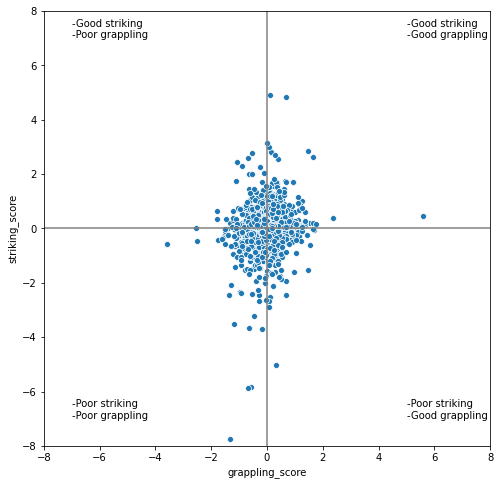

In [65]:
fig, ax = plt.subplots(1,1, figsize=(8,8))

# set limits
ax.set_ylim(-8,8)
ax.set_xlim(-8,8)

# draw reference lines
ax.plot([-8, 8], [0,0], c='grey')
ax.plot([0,0], [-8, 8], c='grey')

# label sections
plt.text(-7, 7, '-Good striking\n-Poor grappling')
plt.text(5, 7, '-Good striking\n-Good grappling')
plt.text(5, -7, '-Poor striking\n-Good grappling')
plt.text(-7, -7, '-Poor striking\n-Poor grappling')

sns.scatterplot(exp_fighters['grappling_score'], exp_fighters['striking_score'])

### Conclusion
The results of this graph reveals the relationship between how grappling and striking complement each other. Notice how the outliers of this graph form a cross; they barely reach out towards the corners of the graph. This is because our striking and grappling scores are calculated using differentials which are essentially a hybrid of their offense and defense. To demonstrate this, let's look at a hypothetical fighter in the graph below, who we'll mark with a green triangle.

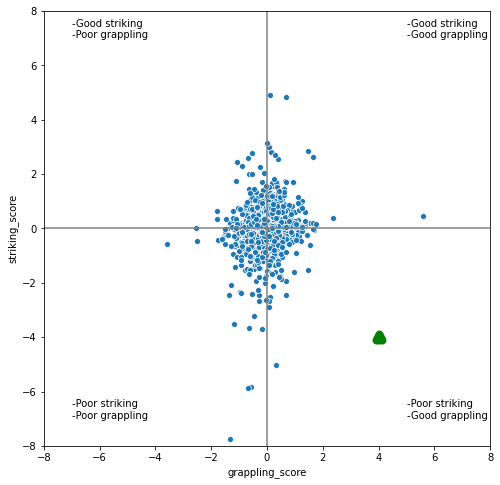

In [71]:
fig, ax = plt.subplots(1,1, figsize=(8,8))

# set limits
ax.set_ylim(-8,8)
ax.set_xlim(-8,8)

# draw reference lines
ax.plot([-8, 8], [0,0], c='grey')
ax.plot([0,0], [-8, 8], c='grey')

# label sections
plt.text(-7, 7, '-Good striking\n-Poor grappling')
plt.text(5, 7, '-Good striking\n-Good grappling')
plt.text(5, -7, '-Poor striking\n-Good grappling')
plt.text(-7, -7, '-Poor striking\n-Poor grappling')

sns.scatterplot(exp_fighters['grappling_score'], exp_fighters['striking_score'])
ax.scatter(4, -4, marker='^', c='green', linewidths=8)

If that green fighter were to exist, his position on the x axis would indicate that he's one of the best grapplers in UFC history. But his location on the y-axis would indicate that he is also one of the worst strikers in history. But, in order for a fighter to have such a low striking score, he would have to take a significant amount of hits while standing, and/or he would have been knocked down a lot throughout his career. The reason why this is so unlikely is that if he were such a great grappler, he would likely take his opponents down before they had an opportunity to do so much damage on the feet.

### Using the current mean and standard deviation as constants
In order to make sure that the striking and grappling scores are consistent over time, I'm going to calculate the z-scores of fighters in previous fights using the current mean and median of each statr as constants.

In [56]:
exp_fighters.describe()

,g_ss_s_p15m_di,td_s_p15m_di,ps_p15m_di,rev_p15m_di,sba_p15m_di,s_ss_s_p15m_di,kd_p15m_di,bouts,striking_score,grappling_score
count,1243.000000,1243.000000,1243.000000,1243.000000,1243.000000,1243.000000,1243.000000,1243.000000,1.243000e+03,1243.000000
mean,-1.470205,-0.126824,-0.211246,-0.001733,-0.023809,-1.396485,-0.136253,7.992759,7.145442e-18,0.000000
std,16.011697,2.015315,2.529548,0.396593,1.589072,17.974866,2.815982,5.551177,8.308359e-01,0.563880
min,-144.784717,-6.670549,-17.371622,-3.252101,-15.564487,-129.971011,-36.000000,3.000000,-7.752954e+00,-3.568457
25%,-7.348485,-1.333333,-1.410352,-0.108836,-0.585124,-10.823771,-0.621142,4.000000,-3.018800e-01,-0.313237
50%,-0.662080,-0.236842,-0.114825,0.000000,0.000000,-1.546533,0.000000,6.000000,1.668396e-02,0.039952
75%,5.968795,1.092742,1.188718,0.110925,0.527204,9.066998,0.500230,10.000000,3.703492e-01,0.317200
max,73.321805,8.333333,13.220946,5.571429,19.497616,67.154036,23.275862,35.000000,4.914362e+00,5.590907


In [58]:
### Grappling
#ground strikes
g_ss_mu = -1.470205
g_ss_std = 16.011697
# takedowns
td_mu = -0.126824
td_std = 2.015315
# passes
ps_mu = -0.211246
ps_std = 2.529548
# reversals
ps_mu = -0.001733
ps_std = 0.396593
# reversals
sba_mu = -0.023809
sba_std = 1.589072

### Striking
# standing strikes
s_ss_mu = -1.470205
s_ss_std = 16.011697
# knockdowns
kd_mu = -0.126824
kd_std = 2.015315

### Calculating the striking score using the constants

In [59]:
s_ss_test = (exp_fighters['s_ss_s_p15m_di']-s_ss_mu)/s_ss_std
kd_test = (exp_fighters['kd_p15m_di']-kd_mu)/kd_std